In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE

from tqdm import tqdm

from prototypicalbeats.prototraining import ProtoBEATsModel
from datamodules.miniECS50DataModule import miniECS50DataModule

In [72]:
model = ProtoBEATsModel()
checkpoints = torch.load("/app/prototypicalbeats/lightning_logs/version_49/checkpoints/epoch=14-step=1500.ckpt")
model.load_state_dict(checkpoints["state_dict"])

<All keys matched successfully>

In [188]:
# Load only the validation dataset 
data_module = miniECS50DataModule()
test_loader = data_module.test_dataloader()

In [190]:
data_module.n_task_test

10

In [191]:
def evaluate_on_one_task(
    n_way: int,
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int, torch.Tensor, torch.Tensor]:
    """
    Returns the number of correct predictions of query labels, the total 
    number of predictions, and the coordinates of the prototypes and query images.
    """
    support_embeddings, _ = model.get_embeddings(support_images.cuda(), padding_mask=None)
    prototypes = model.get_prototypes(support_embeddings, support_labels.cuda(), n_way)
    prototypes = prototypes.detach().cpu()
    
    query_embeddings, _ = model.get_embeddings(query_images.cuda(), padding_mask=None)
    query_embeddings = query_embeddings.detach().cpu()

    return (
        torch.max(
            model(
                support_images.cuda(), 
                support_labels.cuda(), 
                query_images.cuda(),
            )
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels), prototypes, query_embeddings


def evaluate(data_loader: DataLoader, model, n_way, n_task):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0
    all_prototypes = []
    all_query_embeddings = []
    all_query_labels = []

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval().to("cuda")
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total, prototypes, query_embeddings = evaluate_on_one_task(
                n_way, support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct
            all_prototypes.append(prototypes)
            all_query_embeddings.append(query_embeddings)
            all_query_labels.append(query_labels)

    # Concatenate all the prototypes and drop the token dimension
    all_prototypes = torch.cat(all_prototypes, dim=0)
    all_prototypes = all_prototypes[:,-1,:]
    all_prototypes = all_prototypes.view(n_way, n_task, all_prototypes.shape[1]).mean(dim=1)
    
    # Calculate the mean
    all_query_embeddings = torch.cat(all_query_embeddings, dim=0)
    all_query_embeddings = all_query_embeddings[:,-1,:]
    all_query_embeddings = all_query_embeddings.view(50, 10, 768).mean(dim=1)
    
    all_query_labels = torch.cat(all_query_labels, dim=0)

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

    return prototypes, all_query_embeddings, all_query_labels

In [192]:
all_prototypes, all_query_embeddings, all_query_labels = evaluate(test_loader, model, 5, n_task=data_module.n_task_test)

 20%|██        | 2/10 [00:25<01:40, 12.56s/it]

In [166]:
all_query_labels = all_query_labels[:50]
proto_query = torch.cat([all_prototypes, all_query_embeddings])
all_labels = torch.cat([torch.tensor([5,5,5,5,5,]), all_query_labels])

In [179]:
all_query_embeddings = all_query_embeddings[:,-1,:]

tensor([[-0.3920, -0.4304, -0.6433,  ..., -0.9020, -0.3458, -0.5190],
        [ 0.2411,  0.1170, -0.0973,  ..., -0.1960,  0.4911,  0.0683],
        [ 0.4792,  0.6014, -0.1865,  ...,  0.3615, -0.6745,  0.4891],
        ...,
        [-0.3417, -0.3843, -0.6144,  ..., -0.8569, -0.2522, -0.4709],
        [ 0.2403,  0.1138, -0.0991,  ..., -0.2023,  0.4905,  0.0691],
        [-0.4647,  0.1111,  0.4968,  ...,  0.5928, -0.0934, -0.0602]])

In [184]:
all_query_embeddings.shape

torch.Size([500, 768])

In [185]:
all_query_embeddings.view(50,10,768)

tensor([[[-0.3968, -0.4214, -0.6576,  ..., -0.9010, -0.3519, -0.5142],
         [-0.3980, -0.4377, -0.6541,  ..., -0.9158, -0.3530, -0.5216],
         [-0.3952, -0.4269, -0.6421,  ..., -0.9027, -0.3474, -0.5228],
         ...,
         [-0.3901, -0.4294, -0.6540,  ..., -0.9004, -0.3427, -0.5243],
         [-0.3735, -0.4257, -0.5968,  ..., -0.8651, -0.3411, -0.5103],
         [-0.3977, -0.4072, -0.6494,  ..., -0.9123, -0.3348, -0.5196]],

        [[ 0.2303,  0.1000, -0.0600,  ..., -0.2564,  0.6093,  0.0074],
         [ 0.2132,  0.0479, -0.0830,  ..., -0.2844,  0.6048,  0.0161],
         [ 0.2107,  0.0494, -0.0831,  ..., -0.2756,  0.6037,  0.0160],
         ...,
         [ 0.2159,  0.0519, -0.0786,  ..., -0.2813,  0.6060,  0.0146],
         [ 0.2154,  0.0583, -0.0788,  ..., -0.2779,  0.6037,  0.0198],
         [ 0.2404,  0.1549, -0.0422,  ..., -0.2261,  0.5867,  0.0598]],

        [[ 0.4711,  0.6288, -0.1874,  ...,  0.3698, -0.6883,  0.5079],
         [ 0.4787,  0.5927, -0.1853,  ...,  0

In [176]:
all_query_labels

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [164]:
def get_2d_features(features, perplexity):
    tsne = TSNE(n_components=2, perplexity=perplexity)
    features_2d = tsne.fit_transform(features)

    return features_2d

def get_figure(features_2d, labels, fig_name):

    query_2d = features_2d[5:]
    query_labels = labels[5:]

    proto_2d = features_2d[:5]
    proto_labels = labels[:5]

    fig = sns.scatterplot(x=query_2d[:, 0], y=query_2d[:, 1], hue=query_labels, palette="deep")
    sns.scatterplot(x=proto_2d[:, 0], y=proto_2d[:, 1], hue=proto_labels, palette="deep", marker='s', s=100)
    
    sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))
    fig.get_figure().savefig(fig_name, bbox_inches="tight")
    plt.show()

In [146]:
import seaborn as sns


features = proto_query[:, -1, :]
features_2d = TSNE(n_components=2, perplexity=7).fit_transform(features)

/usr/local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


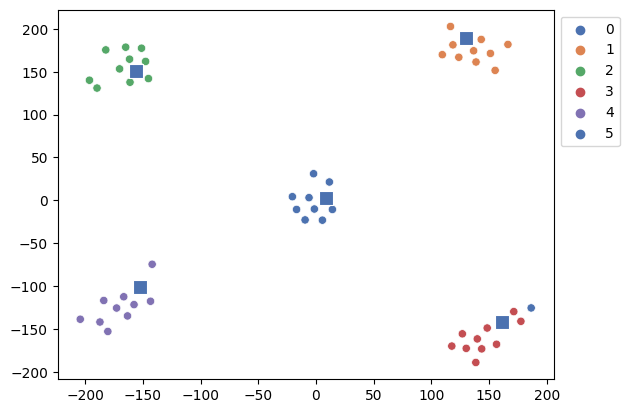

In [165]:

get_figure(features_2d, all_labels, "protoembeddings.png")